# Musinsa standard top1 item by review size recommender system trial
* for boaz

## 환경설정

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/BOAZ/분석adv

/content/drive/MyDrive/BOAZ/분석adv


In [4]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 536 kB/s 
     |████████████████████████████████| 453 kB 59.4 MB/s 


In [5]:
# 데이터 조작 관련
import pandas as pd
import numpy as np
import seaborn as sns
import re
import io

# 한국어 nlp
from konlpy.tag import *   # 모든 형태소분석기 import 하기
#1. hannanum = Hannanum()
#2. kkma = Kkma()
#3. komoran = Komoran()
#4. okt = Okt()

okt = Okt()

### 위 4개중 원하는 형태소분석기를 사용하면 됨 --> okt추천

# 영어 nlp 관련
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

# 시각화 관련
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

# 기타
from tqdm import tqdm_notebook, tqdm   # for문 진행상황 눈으로 확인 (loading bar)
import datetime

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

## 파일불러오기

In [ ]:
df = pd.read_csv('무탠다드_top1_테이퍼드 히든 밴딩 크롭 슬랙스_ANSI.csv',encoding = 'cp949')
df.head()

,Unnamed: 0,user,gender,height,weight,item,size,star,content,size_eval,bright_eval,color_eval,thick_eval
0,0,LV 4 뉴봉,남성,180cm,85kg,테이퍼드 히든 밴딩 크롭 슬랙스 [다크 브라운],34,4,무신사 슬랙스 평이 좋아서 구매해봤습니다. 색과 퀄리티 두께감 다 마음에 들었는데 ...,보통이에요,어두워요,선명해요,두꺼워요
1,1,LV 4 뉴비루키맴버,남성,178cm,90kg,테이퍼드 히든 밴딩 크롭 슬랙스 [다크 그레이],36,5,무탠다드 슬랙스 편안하니 좋아요가볍게 입기 좋아요큰사이즈도 있어 만족해요,보통이에요,보통이에요,보통이에요,보통이에요
2,2,LV 4 뉴비루키맴버,남성,178cm,90kg,테이퍼드 히든 밴딩 크롭 슬랙스 [차콜 그레이],36,5,무탠다드 슬랙스 편안하니 좋아요가볍게 입기 좋아요큰사이즈도 있어 만족해요,보통이에요,보통이에요,보통이에요,보통이에요
3,3,LV 4 J___park,남성,176cm,72kg,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],31,4,바지자체는 너무 예쁘고 스판도 좋아요 하지만 허벅지 좀 있는분들은 한치수 업 추천드...,보통이에요,보통이에요,보통이에요,보통이에요
4,4,LV 5 맨동야,남성,181cm,76kg,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],32,5,참 좋아요두번째 구매인데 기본 가성비템으로좋습니다,보통이에요,보통이에요,보통이에요,보통이에요


In [ ]:
df["size_eval"]=df["size_eval"].replace('보통이에요','0',regex = True)
df["size_eval"]=df["size_eval"].replace('커요','1',regex = True)
df["size_eval"]=df["size_eval"].replace('작아요','-1',regex = True)
df["height"]=df["height"].replace('cm','',regex = True)
df["weight"]=df["weight"].replace('kg','',regex = True)
df["height"] = pd.to_numeric(df["height"])
df["weight"] = pd.to_numeric(df["weight"])
df["size_eval"] = pd.to_numeric(df["size_eval"])
df.head()

,Unnamed: 0,user,gender,height,weight,item,size,star,content,size_eval,bright_eval,color_eval,thick_eval
0,0,LV 4 뉴봉,남성,180,85,테이퍼드 히든 밴딩 크롭 슬랙스 [다크 브라운],34,4,무신사 슬랙스 평이 좋아서 구매해봤습니다. 색과 퀄리티 두께감 다 마음에 들었는데 ...,0,어두워요,선명해요,두꺼워요
1,1,LV 4 뉴비루키맴버,남성,178,90,테이퍼드 히든 밴딩 크롭 슬랙스 [다크 그레이],36,5,무탠다드 슬랙스 편안하니 좋아요가볍게 입기 좋아요큰사이즈도 있어 만족해요,0,보통이에요,보통이에요,보통이에요
2,2,LV 4 뉴비루키맴버,남성,178,90,테이퍼드 히든 밴딩 크롭 슬랙스 [차콜 그레이],36,5,무탠다드 슬랙스 편안하니 좋아요가볍게 입기 좋아요큰사이즈도 있어 만족해요,0,보통이에요,보통이에요,보통이에요
3,3,LV 4 J___park,남성,176,72,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],31,4,바지자체는 너무 예쁘고 스판도 좋아요 하지만 허벅지 좀 있는분들은 한치수 업 추천드...,0,보통이에요,보통이에요,보통이에요
4,4,LV 5 맨동야,남성,181,76,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],32,5,참 좋아요두번째 구매인데 기본 가성비템으로좋습니다,0,보통이에요,보통이에요,보통이에요


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   980 non-null    int64 
 1   user         980 non-null    object
 2   gender       980 non-null    object
 3   height       980 non-null    int64 
 4   weight       980 non-null    int64 
 5   item         980 non-null    object
 6   size         980 non-null    int64 
 7   star         980 non-null    int64 
 8   content      980 non-null    object
 9   size_eval    980 non-null    int64 
 10  bright_eval  980 non-null    object
 11  color_eval   980 non-null    object
 12  thick_eval   980 non-null    object
dtypes: int64(6), object(7)
memory usage: 99.7+ KB


## 피벗 파일 생성

In [ ]:
pivot = df.pivot_table("size_eval",index = "user",columns = "size")
pivot.head()

size,26,27,28,29,30,31,32,33,34,36,38,40
user,,,,,,,,,,,,
LV 2 [ㅡ3ㅡ],NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LV 2 겅부경경경,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
LV 2 게리!,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
LV 2 근육질소년,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN
LV 2 눈빛준,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pivot.to_csv('추천시스템시도2_피벗.csv')

## 피벗 파일 데이터 수정
* 별점과 같이 5점을 기준
* '보통이에요' 일 경우
  * 구매사이즈-1: 3점, 구매사이즈: 5점, 구매사이즈+1: 3점
* '커요'일 경우 
  * 구매사이즈-2: 3점, 구매사이즈-1: 4점, 구매사이즈: 4점
* '작아요'일 경우 
  * 구매사이즈: 3점, 구매사이즈+1: 5점, 구매사이즈+2 : 3점

** 커요일 경우 그래도 입을 수 있고 맘에 안든다기 보다는 생각보다 크네~ 이정도일 수도 있음. 그러나 작아요일 경우 맘에안들고 안입게되는 경우가 커요에 비해 더 많다. 그래서 다르게 점수를 매겨야함->이후 추후논의 필요

** 사이즈표: 26,27,28,29,30,31,32,33,34,36,38,40,42

In [7]:
df1 = pd.read_csv('추천시스템시도2_피벗.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    634 non-null    object 
 1   26      5 non-null      float64
 2   27      15 non-null     float64
 3   28      40 non-null     float64
 4   29      55 non-null     float64
 5   30      106 non-null    float64
 6   31      111 non-null    float64
 7   32      142 non-null    float64
 8   33      81 non-null     float64
 9   34      60 non-null     float64
 10  36      28 non-null     float64
 11  38      9 non-null      float64
 12  40      1 non-null      float64
dtypes: float64(12), object(1)
memory usage: 64.5+ KB


In [8]:
df1.head()

,user,26,27,28,29,30,31,32,33,34,36,38,40
0,LV 2 [ㅡ3ㅡ],NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LV 2 겅부경경경,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,LV 2 게리!,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,LV 2 근육질소년,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN
4,LV 2 눈빛준,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#작아요 

df1.loc[df1['26'] == -1, '27'] = 5
df1.loc[df1['26'] == -1, '28'] = 3
df1.loc[df1['26'] == -1, '26'] = 3

df1.loc[df1['27'] == -1, '28'] = 5
df1.loc[df1['27'] == -1, '29'] = 3
df1.loc[df1['27'] == -1, '27'] = 3

df1.loc[df1['28'] == -1, '29'] = 5
df1.loc[df1['28'] == -1, '30'] = 3
df1.loc[df1['28'] == -1, '28'] = 3

df1.loc[df1['29'] == -1, '30'] = 5
df1.loc[df1['29'] == -1, '31'] = 3
df1.loc[df1['29'] == -1, '29'] = 3

df1.loc[df1['30'] == -1, '31'] = 5
df1.loc[df1['30'] == -1, '32'] = 3
df1.loc[df1['30'] == -1, '30'] = 3

df1.loc[df1['31'] == -1, '32'] = 5
df1.loc[df1['31'] == -1, '33'] = 3
df1.loc[df1['31'] == -1, '31'] = 3

df1.loc[df1['32'] == -1, '33'] = 5
df1.loc[df1['32'] == -1, '34'] = 3
df1.loc[df1['32'] == -1, '32'] = 3

df1.loc[df1['33'] == -1, '34'] = 5
df1.loc[df1['33'] == -1, '36'] = 3
df1.loc[df1['33'] == -1, '33'] = 3

df1.loc[df1['34'] == -1, '36'] = 5
df1.loc[df1['34'] == -1, '38'] = 3
df1.loc[df1['34'] == -1, '34'] = 3

df1.loc[df1['36'] == -1, '38'] = 5
df1.loc[df1['36'] == -1, '40'] = 3
df1.loc[df1['36'] == -1, '36'] = 3

df1.loc[df1['38'] == -1, '40'] = 5
df1.loc[df1['38'] == -1, '42'] = 3
df1.loc[df1['38'] == -1, '38'] = 3

#df1.loc[df1['40'] == -1, '41'] = 5
df1.loc[df1['40'] == -1, '42'] = 5
df1.loc[df1['40'] == -1, '40'] = 3


In [10]:
#보통이에요
#df1[df1['26'] == 0, '25'] = 3
df1.loc[df1['26'] == 0, '27'] = 3
df1.loc[df1['26'] == 0, '26'] = 5

df1.loc[df1['27'] == 0, '26'] = 3
df1.loc[df1['27'] == 0, '28'] = 3
df1.loc[df1['27'] == 0, '27'] = 5

df1.loc[df1['28'] == 0, '27'] = 3
df1.loc[df1['28'] == 0, '29'] = 3
df1.loc[df1['28'] == 0, '28'] = 5

df1.loc[df1['29'] == 0, '28'] = 3
df1.loc[df1['29'] == 0, '30'] = 3
df1.loc[df1['29'] == 0, '29'] = 5

df1.loc[df1['30'] == 0, '29'] = 3
df1.loc[df1['30'] == 0, '31'] = 3
df1.loc[df1['30'] == 0, '30'] = 5

df1.loc[df1['31'] == 0, '30'] = 3
df1.loc[df1['31'] == 0, '32'] = 3
df1.loc[df1['31'] == 0, '31'] = 5

df1.loc[df1['32'] == 0, '31'] = 3
df1.loc[df1['32'] == 0, '33'] = 3
df1.loc[df1['32'] == 0, '32'] = 5

df1.loc[df1['33'] == 0, '32'] = 3
df1.loc[df1['33'] == 0, '34'] = 3
df1.loc[df1['33'] == 0, '33'] = 5

df1.loc[df1['34'] == 0, '33'] = 3
df1.loc[df1['34'] == 0, '36'] = 3
df1.loc[df1['34'] == 0, '34'] = 5

df1.loc[df1['36'] == 0, '34'] = 3
df1.loc[df1['36'] == 0, '38'] = 3
df1.loc[df1['36'] == 0, '36'] = 5

df1.loc[df1['38'] == 0, '36'] = 3
df1.loc[df1['38'] == 0, '40'] = 3
df1.loc[df1['38'] == 0, '38'] = 5

df1.loc[df1['40'] == 0, '38'] = 3
#df1[df1['40'] == 0, '41'] = 3
df1.loc[df1['40'] == 0, '40'] = 5

In [11]:
 #커요
#df1[df1['26'] == 1, '24'] = 3
#df1[df1['26'] == 1, '25'] = 4
df1.loc[df1['26'] == 1, '26'] = 4

#df1.loc[df1['27'] == 1, '25'] = 3
df1.loc[df1['27'] == 1, '26'] = 4
df1.loc[df1['27'] == 1, '27'] = 4

df1.loc[df1['28'] == 1, '26'] = 3
df1.loc[df1['28'] == 1, '27'] = 4
df1.loc[df1['28'] == 1, '28'] = 4

df1.loc[df1['29'] == 1, '27'] = 3
df1.loc[df1['29'] == 1, '28'] = 4
df1.loc[df1['29'] == 1, '29'] = 4

df1.loc[df1['30'] == 1, '28'] = 3
df1.loc[df1['30'] == 1, '29'] = 4
df1.loc[df1['30'] == 1, '30'] = 4

df1.loc[df1['31'] == 1, '29'] = 3
df1.loc[df1['31'] == 1, '30'] = 4
df1.loc[df1['31'] == 1, '31'] = 4

df1.loc[df1['32'] == 1, '30'] = 3
df1.loc[df1['32'] == 1, '31'] = 4
df1.loc[df1['32'] == 1, '32'] = 4

df1.loc[df1['33'] == 1, '31'] = 3
df1.loc[df1['33'] == 1, '32'] = 4
df1.loc[df1['33'] == 1, '33'] = 4

df1.loc[df1['34'] == 1, '32'] = 3
df1.loc[df1['34'] == 1, '33'] = 4
df1.loc[df1['34'] == 1, '34'] = 4

df1.loc[df1['36'] == 1, '33'] = 3
df1.loc[df1['36'] == 1, '34'] = 4
df1.loc[df1['36'] == 1, '36'] = 4

df1.loc[df1['38'] == 1, '34'] = 3
df1.loc[df1['38'] == 1, '36'] = 4
df1.loc[df1['38'] == 1, '38'] = 4

df1.loc[df1['40'] == 1, '36'] = 3
df1.loc[df1['40'] == 1, '38'] = 4
df1.loc[df1['40'] == 1, '40'] = 4



In [12]:
df1.head()

,user,26,27,28,29,30,31,32,33,34,36,38,40,42
0,LV 2 [ㅡ3ㅡ],NaN,3.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LV 2 겅부경경경,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,NaN
2,LV 2 게리!,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN
3,LV 2 근육질소년,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,NaN,NaN
4,LV 2 눈빛준,NaN,NaN,NaN,3.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1.to_csv('after_top1.csv')

## 최종 파일 및 추천시스템
* 구현한 것: 유저를 검색-> 사이즈추천

* 고민한것
1. 실사용자와 키와 몸무게가 비슷한 군집 혹은 유저 도출
2. 도출된 군집이나 유저에게 맞는 사이즈 추천(현 단계)

1->2 순서로 사이즈추천 시스템 완성(이후 별점 데이터를 활용하거나 그외의 요소는 추가될 것)

In [13]:
df2 = pd.read_csv('after_top1.csv')
df2.fillna(0,inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  634 non-null    int64  
 1   user        634 non-null    object 
 2   26          634 non-null    float64
 3   27          634 non-null    float64
 4   28          634 non-null    float64
 5   29          634 non-null    float64
 6   30          634 non-null    float64
 7   31          634 non-null    float64
 8   32          634 non-null    float64
 9   33          634 non-null    float64
 10  34          634 non-null    float64
 11  36          634 non-null    float64
 12  38          634 non-null    float64
 13  40          634 non-null    float64
 14  42          634 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 74.4+ KB


In [14]:
df2 = df2.drop(['Unnamed: 0'],axis = 1)
df2 = df2.drop(['user'],axis = 1)

In [16]:
#user X size
df2.head(20)

,26,27,28,29,30,31,32,33,34,36,38,40,42
0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0
2,0.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0
4,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#numpy matrix로 만들기
matrix =df2.to_numpy()
#사용자의 평균 평점
user_ratings_mean = np.mean(matrix,axis = 1)
#기존 df에서 사용자 평균 평점 빼기
matrix_user_mean = matrix - user_ratings_mean.reshape(-1,1)

In [18]:
pd.DataFrame(matrix_user_mean,columns = df2.columns).head()

,26,27,28,29,30,31,32,33,34,36,38,40,42
0,-0.846154,2.153846,4.153846,2.153846,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154
1,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,2.153846,4.153846,2.153846,-0.846154
2,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,2.153846,4.153846,2.153846,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154
3,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,2.153846,4.153846,2.153846,-0.846154,-0.846154
4,-0.846154,-0.846154,-0.846154,2.153846,4.153846,2.153846,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154,-0.846154


* SVD 비고와 링크 참고

In [19]:
#SVD사용
#U행렬, sigma행렬, V전치행렬
#k=잠재벡터크기, 일단 참고한 예제에서의 값을 그대로 썼는데 이후 변화시켜가면 최적의 값을 찾아야 한다.
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(matrix_user_mean,k = 12)

In [20]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(634, 12)
(12,)
(12, 13)


In [21]:
#0이 포함된 대칭행렬로 변환
sigma = np.diag(sigma)

In [22]:
#원본행렬로 복구 + 사용자평균rating
svd_user_predicted_ratings = np.dot(np.dot(U, sigma),Vt) + user_ratings_mean.reshape(-1,1)

In [23]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df2.columns)
df_svd_preds.head()

,26,27,28,29,30,31,32,33,34,36,38,40,42
0,2.997602e-15,3.000000e+00,5.000000e+00,3.000000e+00,1.443290e-15,1.443290e-15,5.329071e-15,1.776357e-15,1.554312e-15,1.443290e-15,1.776357e-15,2.886580e-15,2.442491e-15
1,-2.553513e-15,-2.886580e-15,-2.442491e-15,-1.443290e-15,-5.551115e-16,-1.776357e-15,-1.554312e-15,-1.665335e-15,-4.329870e-15,3.000000e+00,5.000000e+00,3.000000e+00,-6.661338e-16
2,1.554312e-15,1.332268e-15,1.776357e-15,1.332268e-15,7.771561e-16,3.000000e+00,5.000000e+00,3.000000e+00,8.881784e-16,1.998401e-15,9.992007e-16,9.992007e-16,4.440892e-16
3,2.220446e-16,0.000000e+00,-1.110223e-15,0.000000e+00,2.886580e-15,8.881784e-16,6.661338e-16,7.771561e-16,3.000000e+00,5.000000e+00,3.000000e+00,1.110223e-16,1.110223e-15
4,3.330669e-16,8.881784e-16,5.551115e-16,3.000000e+00,5.000000e+00,3.000000e+00,1.110223e-15,1.554312e-15,2.664535e-15,1.554312e-15,2.109424e-15,1.221245e-15,-1.110223e-16


In [24]:
#함수 생성
#유저입력->사이즈추천 5개
def recommend_size(user):
  return df_svd_preds.iloc[user].sort_values(ascending = False)[:5]

In [ ]:
recommend_size(3)
#유저 3 : 34 샀을 때 '작아요'라고 남겼고 36이 나왔음을 확인!

36    5.000000e+00
34    3.000000e+00
38    3.000000e+00
30    2.886580e-15
42    1.110223e-15
Name: 3, dtype: float64

In [25]:
recommend_size(13)
#유저13 : 30 샀을때 '커요'라고 남겼고 29와 30을 추천

29    4.000000e+00
30    4.000000e+00
28    3.000000e+00
32    4.329870e-15
34    3.441691e-15
Name: 13, dtype: float64

## 비고(참고링크)
* https://tpwkcorqhd.tistory.com/37
* 여러값 바꾸기 참고: https://developer-ping9.tistory.com/111 : 
 * df[df['주거형태']=='자가', 'X'] =1

* 영화 추천시스템: https://lsjsj92.tistory.com/570 
* SVD U,sigma, Vt 설명: https://sungkee-book.tistory.com/12

* https://romg2.github.io/mlguide/02_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-09.-%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C-%EC%B5%9C%EA%B7%BC%EC%A0%91-%EC%9D%B4%EC%9B%83/


## SVD 참고

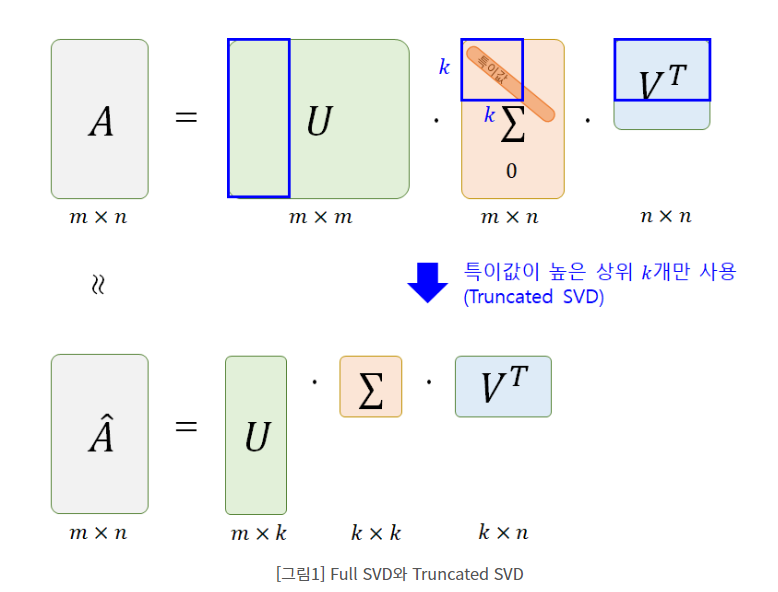

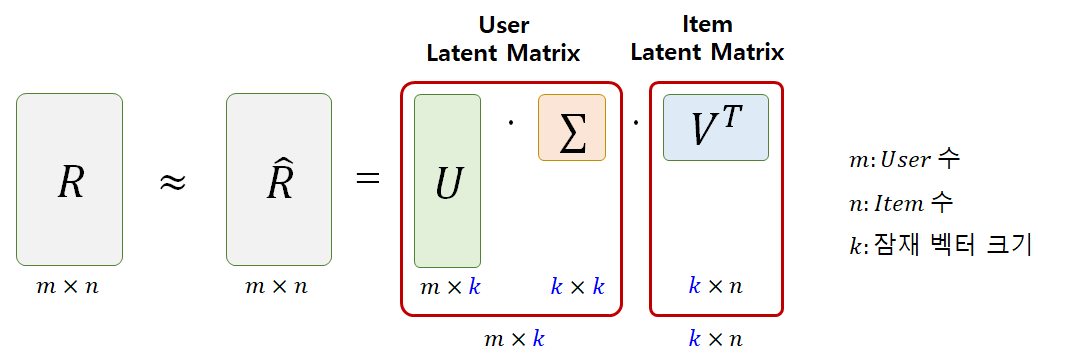